In [1]:
### Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
import bayes_opt
from scipy.stats import rankdata

In [2]:
warnings.filterwarnings("ignore")

In [3]:
## read the train dataset
rainfall_df = pd.read_csv("./train.csv")

test_df = pd.read_csv("./test.csv")

sample_submission = pd.read_csv("./sample_submission.csv")

In [4]:
def explore_data(df):
    
    ## Check dataset shape
    print(f"****** Explore dataset shape*****\n\
The dataset has {df.shape[0]:,} rows and {df.shape[1]:,} colmns")
    
    ## Check for duplicates in dataset
    print(f"\nThere are {df.duplicated().sum():,} duplicated records in the dataset")
    
    ## Check for missing values
    print("\nCheck missing values in dataset\nColumn name: Value")
    for col in df.columns:
        print(f"{col}: {df[col].isna().sum():,} missing values")
        
    ## Check Data Information
    print("\n***** Data Information *****")
    print(f"{df.info()}")
    
    ## Check Data Statistics
    print(f"\nStatistics Data\n{df.describe()}")
    
    ## Explore the target variable distribution
    plt.figure(figsize=(4,3))
    sns.countplot(data=df, x=df.columns[-1])
    plt.title("Distribution of target variable")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
    
    

****** Explore dataset shape*****
The dataset has 2,190 rows and 13 colmns

There are 0 duplicated records in the dataset

Check missing values in dataset
Column name: Value
id: 0 missing values
day: 0 missing values
pressure: 0 missing values
maxtemp: 0 missing values
temparature: 0 missing values
mintemp: 0 missing values
dewpoint: 0 missing values
humidity: 0 missing values
cloud: 0 missing values
sunshine: 0 missing values
winddirection: 0 missing values
windspeed: 0 missing values
rainfall: 0 missing values

***** Data Information *****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   f

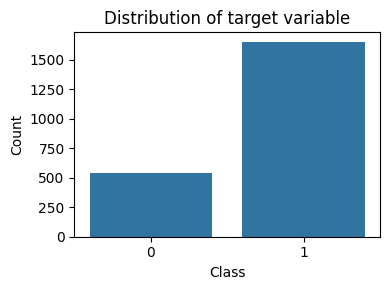

In [5]:
## call the explore function
explore_data(rainfall_df)

In [ ]:
## Separate features from target variable
rainfall = rainfall_df.drop(columns=["id","rainfall"], axis=1)
target = rainfall_df[["rainfall"]]

### Resample the trainset to jandle class imbalace
X_resampled, target_resampled = SMOTE(random_state=42).fit_resample(rainfall, target)




In [9]:
# solution 1

## Build the objective function for the model

def rfc(n_estimators,max_depth,criterion, max_features ):
    
    criterions = ["gini", "entropy", "log_loss"] 
    max_feature = ["sqrt", "log2"]
    
    params = {
        "n_estimators" : int(round(n_estimators)),
        "max_depth" : int(round(max_depth)),
        "criterion" : criterions[int(round(criterion))],
        "max_features" : max_feature[int(round(max_features))]
    }
    
    ### Use Stratified-10-fold
    strf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) 
    
    roc_scores = []
    for train_index, val_index in strf.split(X_resampled,target_resampled):
        
        model = RandomForestClassifier(**params)
        model.fit(X_resampled.iloc[train_index], target_resampled.iloc[train_index])
        pred_proba = model.predict_proba(X_resampled.iloc[val_index])[:,1]
        val_roc_auc = roc_auc_score(target_resampled.iloc[val_index], pred_proba)
        roc_scores.append(val_roc_auc)
        
    return np.mean(roc_scores)

### Set the search space
pbound = {
    "n_estimators" : (100, 1000),
    "max_depth" : (3,15),
    "criterion" : (0,2),
    "max_features" : (0,1)
}

bayes_optmz = bayes_opt.BayesianOptimization(f=rfc, pbounds=pbound, verbose=2)

bayes_optmz.maximize(init_points=20 ,n_iter=40)

|   iter    |  target   | criterion | max_depth | max_fe... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.9477    | 0.03063   | 11.7      | 0.7438    | 262.6     |
| 2         | 0.922     | 0.8879    | 4.833     | 0.9824    | 128.0     |
| 3         | 0.9219    | 0.7903    | 5.421     | 0.2809    | 497.9     |
| 4         | 0.9273    | 0.6346    | 6.196     | 0.8862    | 179.2     |
| 5         | 0.9315    | 0.778     | 7.146     | 0.8202    | 125.5     |
| 6         | 0.9409    | 1.598     | 9.428     | 0.8011    | 941.1     |
| 7         | 0.9365    | 1.172     | 7.976     | 0.6421    | 319.4     |
| 8         | 0.9465    | 1.566     | 11.19     | 0.4344    | 706.7     |
| 9         | 0.9487    | 0.07262   | 13.42     | 0.4199    | 537.3     |
| 10        | 0.9478    | 0.2214    | 11.92     | 0.773     | 988.2     |
| 11        | 0.9267    | 0.9852    | 6.03      | 0.9881    | 264.8     |
| 12        | 0.9328    | 1.404     | 

In [10]:
## Fetch the best model parameters
best_params = bayes_optmz.max["params"]

## convert the parameters to integer
for i in best_params.keys():    
    best_params[i] = int(round(best_params[i]))
    
## update the best parameter values with the actual parameter
criterions = ["gini", "entropy", "log_loss"] 
max_feature = ["sqrt", "log2"]
best_params["criterion"] = criterions[best_params["criterion"]]
best_params["max_features"] = max_feature[best_params["max_features"]]

In [12]:
## Second solution

### define the objective function for the xgb classifier

def xgb(n_estimators,max_depth, learning_rate, subsample,colsample_bytree,gamma,reg_alpha,reg_lambda):
    
    ## create the model parameter dictionary
    params = {"n_estimators": int(round(n_estimators)),
              "max_depth" : int(round(max_depth)),
              "learning_rate": learning_rate,
              "subsample" : subsample,
              "colsample_bytree" : colsample_bytree,
              "eval_metric" : "auc",
              "random_state" : 42,
              "gamma" : gamma,
              "reg_alpha" : reg_alpha,
              "reg_lambda" : reg_lambda,
              "early_stopping_rounds" : 100
              }
    ## use stratified-10fold 
    fold =10
    stkfold = StratifiedKFold(n_splits=fold, shuffle=True, random_state=42)
    val_auc_score = []
    
    for train_idx_2, val_index_2 in stkfold.split(X_resampled,target_resampled):
        X_train = X_resampled.iloc[train_idx_2]
        Y_train = target_resampled.iloc[train_idx_2]
        X_val = X_resampled.iloc[val_index_2]
        Y_val = target_resampled.iloc[val_index_2]
        
        ## initiatile the model
        model = XGBClassifier(**params)
        
        ## fit the model
        model.fit(X_train, Y_train, eval_set = [(X_val, Y_val)])
        
        ## make prediction on the validation set
        prediction = model.predict_proba(X_val)[:,1]
        roc_auc = roc_auc_score(Y_val,prediction)
        
        ## append the score to the list
        val_auc_score.append(roc_auc)
        
        
        return np.mean(val_auc_score)
    


## defind the search space    
pbound = {"n_estimators": (100,1000),
          "max_depth" : (3,15),
          "learning_rate" : (0.01, 0.1),
          "subsample" : (0.8, 1),
          "colsample_bytree" : (0.8, 1),
          "gamma" : (0,1),
          "reg_alpha" : (0,1),
          "reg_lambda": (0,1)
          }

## Initiatize the optimization
bayest_optmz_2 = bayes_opt.BayesianOptimization(f=xgb, pbounds=pbound, random_state=42,verbose=2)

## Run the optimaztion
bayest_optmz_2.maximize(init_points=20 ,n_iter=40)

        
    

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
[0]	validation_0-auc:0.91878
[1]	validation_0-auc:0.92845
[2]	validation_0-auc:0.93267
[3]	validation_0-auc:0.93190
[4]	validation_0-auc:0.93618
[5]	validation_0-auc:0.93727
[6]	validation_0-auc:0.93692
[7]	validation_0-auc:0.93819
[8]	validation_0-auc:0.93761
[9]	validation_0-auc:0.94582
[10]	validation_0-auc:0.94594
[11]	validation_0-auc:0.95036
[12]	validation_0-auc:0.95383
[13]	validation_0-auc:0.95326
[14]	validation_0-auc:0.95722
[15]	validation_0-auc:0.95573
[16]	validation_0-auc:0.95636
[17]	validation_0-auc:0.95619
[18]	validation_0-auc:0.95533
[19]	validation_0-auc:0.95693
[20]	validation_0-auc:0.95653
[21]	validation_0-auc:0.95734
[22]	validation_0-auc:0.95808
[23]	validation_0-auc:0.95854
[24]	validation_0-auc:0.95969
[25]	validation_

In [15]:
## fetch the best parameters
best_params_2 = bayest_optmz_2.max["params"]

## format the best paramaters
best_params_2["max_depth"]=int(round(best_params_2["max_depth"]))
best_params_2["n_estimators"]=int(round(best_params_2["n_estimators"]))
# best_params_2["eval_metric"] = "auc"
# best_params_2["early_stopping_rounds"] = 100


The accuracy of RandomForest classifier is: 0.8909090909090909
The roc_auc_score of RandomForest classifier is: 0.950356453339214



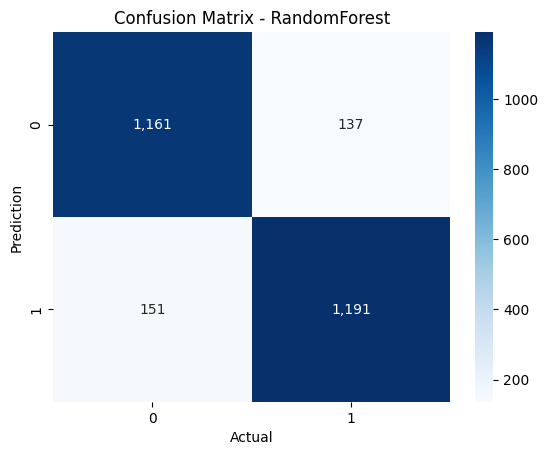

The accuracy of XGBClassifier classifier is: 0.8909090909090909
The roc_auc_score of XGBClassifier classifier is: 0.9523111962878247



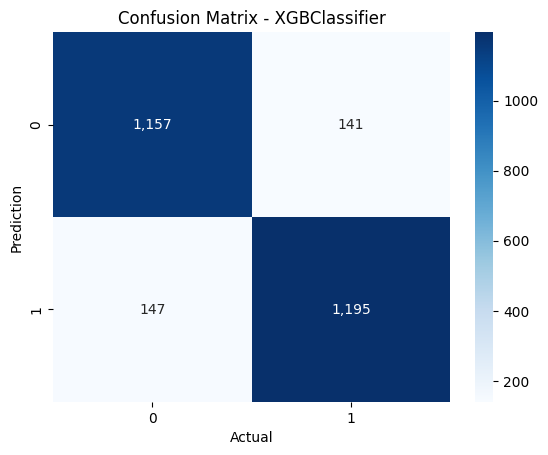

[LightGBM] [Info] Number of positive: 1207, number of negative: 1169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 509
[LightGBM] [Info] Number of data points in the train set: 2376, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507997 -> initscore=0.031989
[LightGBM] [Info] Start training from score 0.031989
[LightGBM] [Info] Number of positive: 1207, number of negative: 1169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 509
[LightGBM] [Info] Number of data points in the train set: 2376, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507997 -> initscore=0.031989
[LightGBM] [Info] Start training from score 0.031989
[LightGBM] [Info] Number o

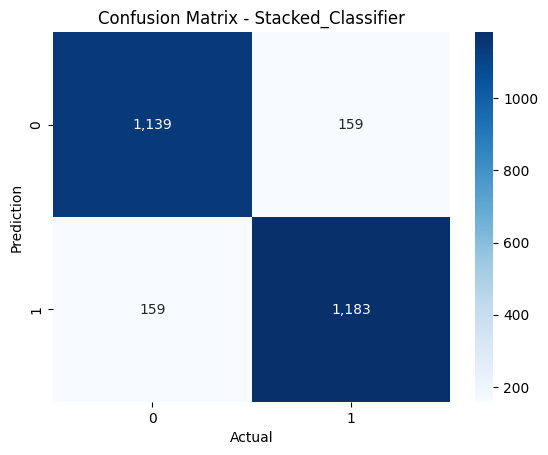

In [16]:

## Create a Stack Ensemble
stacked_classifier = StackingClassifier(estimators=[("RandomFOrest", RandomForestClassifier(**best_params)),
                                                     ("XGBM", XGBClassifier(**best_params_2))],
                                        final_estimator=LGBMClassifier())

## Create disctionary for models
models = {"RandomForest": RandomForestClassifier(**best_params),
          "XGBClassifier": XGBClassifier(**best_params_2),
          "Stacked_Classifier": stacked_classifier}

## Use Stratified 10-fold cross-validation
strkfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for model, classifier in models.items():
    
    ## list of model performance metrics
    model_accuracy = []
    model_roc_auc_score = []
    oof_prediction =np.zeros(len(target_resampled))
    
    for train_idex, val_idx in strkfold.split(X_resampled,target_resampled):
        X_train_, Y_train_ = X_resampled.iloc[train_idex],target_resampled.iloc[train_idex]
        X_val_, Y_val_ = X_resampled.iloc[val_idx],target_resampled.iloc[val_idx]
        classifier.fit(X_train_, Y_train_)
    
        ## Check model accuracy and roc_auc_score
        prediction = classifier.predict(X_val_)
        prediction_prob = classifier.predict_proba(X_val_)        
        accuracy = accuracy_score(Y_val_, prediction)
        roc_auc = roc_auc_score(Y_val_, prediction_prob[:,1])
        
        ## update the out-of-fold prediction
        oof_prediction[val_idx] = prediction
        
        ## append the accuracy and roc to the list
        model_accuracy.append(accuracy)
        model_roc_auc_score.append(roc_auc)
        
    print(f"The accuracy of {model} classifier is: {np.mean(model_accuracy):.4f}")
    print(f"The roc_auc_score of {model} classifier is: {np.mean(model_roc_auc_score):.4f}\n")
    
        ## Confusion Matix
    plt.Figure(figsize=(4,3))
    sns.heatmap(confusion_matrix(target_resampled, oof_prediction), fmt=",",cmap="Blues",annot=True)
    plt.title(f"Confusion Matrix - {model}")
    plt.xlabel("Actual")
    plt.ylabel("Prediction")
    plt.tight_layout
    plt.show()